# Model Training

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(
    "properties_phase2_final.csv",
    low_memory=False
)

print("Loaded shape:", df.shape)

X = df.drop("Price", axis=1)
y = np.log1p(df["Price"])

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))



numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Loaded shape: (11338, 16)
Numeric features: 13
Categorical features: 2


In [2]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
linreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)
y_pred_lr = linreg_pipeline.predict(X_val)

lr_r2 = r2_score(y_val, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))

print("\nLinear Regression")
print("R2:", round(lr_r2, 4))
print("RMSE:", round(lr_rmse, 4))


Linear Regression
R2: 0.8076
RMSE: 0.3609


In [4]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)

rf_r2 = r2_score(y_val, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))

print("\nRandom Forest")
print("R2:", round(rf_r2, 4))
print("RMSE:", round(rf_rmse, 4))


Random Forest
R2: 0.9331
RMSE: 0.2129


In [5]:
gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_val)

gb_r2 = r2_score(y_val, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_gb))

print("\nGradient Boosting")
print("R2:", round(gb_r2, 4))
print("RMSE:", round(gb_rmse, 4))


Gradient Boosting
R2: 0.9269
RMSE: 0.2225


In [6]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "R2": [lr_r2, rf_r2, gb_r2],
    "RMSE": [lr_rmse, rf_rmse, gb_rmse]
}).sort_values(by="R2", ascending=False)

print("\nModel Comparison")
print(results)



Model Comparison
               Model        R2      RMSE
1      Random Forest  0.933088  0.212851
2  Gradient Boosting  0.926915  0.222452
0  Linear Regression  0.807645  0.360888


In [4]:
%pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 5.6 MB/s  0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


# SHAP Explainability

100%|===================| 9065/9070 [17:31<00:00]        

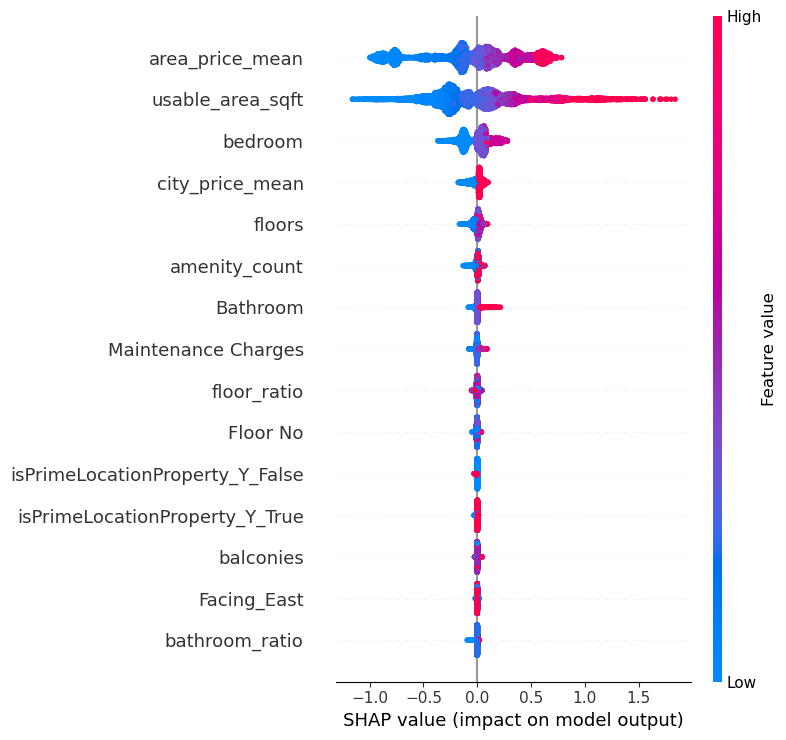

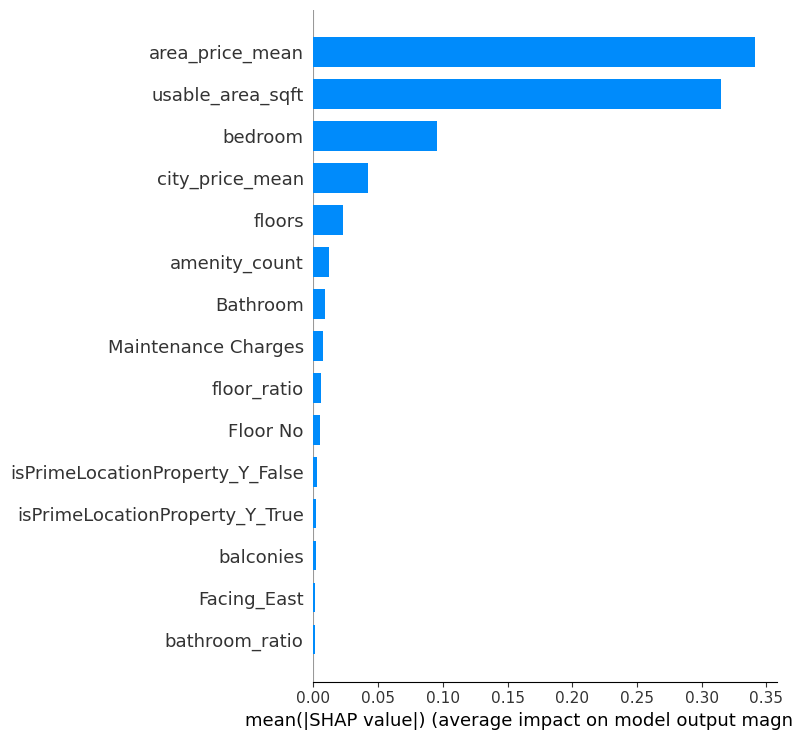

In [7]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(
    "properties_phase2_final.csv",
    low_memory=False
)

X = df.drop("Price", axis=1)
y = np.log1p(df["Price"])

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()


# 3. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)


# 4. Train Model (Random Forest)
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_pipeline.fit(X_train, y_train)



# 5. Prepare Data for SHAP
# Transform features
X_train_transformed = rf_pipeline.named_steps["preprocessor"].transform(X_train)

# Get feature names after encoding
num_features = numeric_features
cat_features = rf_pipeline.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_features, cat_features])



# 6. SHAP Explainer
explainer = shap.Explainer(
    rf_pipeline.named_steps["model"],
    X_train_transformed
)

shap_values = explainer(X_train_transformed)



# 7. SHAP Summary Plot (Global Importance)
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    max_display=15
)



# 8. SHAP Bar Plot (Mean Impact)
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)


# Hyperparameter Tuning

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(
    "C:\\Users\\Utkarsh\\Downloads\\properties_phase2_final.csv",
    low_memory=False
)

X = df.drop("Price", axis=1)
y = np.log1p(df["Price"])


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])


param_distributions = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [10, 15, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 3, 5],
    "model__max_features": ["sqrt", "log2"]
}


random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_

y_pred = best_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("\nBest Parameters:")
print(random_search.best_params_)

print("\nTuned Random Forest Performance")
print("R2:", round(r2, 4))
print("RMSE:", round(rmse, 4))


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters:
{'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None}

Tuned Random Forest Performance
R2: 0.9396
RMSE: 0.2022


# Saving the model

In [11]:
import joblib
import pandas as pd
import numpy as np

model_path = "house_price_rf_model.pkl"

joblib.dump(best_model, model_path)
print("Model saved successfully!")

Model saved successfully!
